In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [2]:
def find_method_descriptor(image, method=None):
    """
    Compute key points and feature descriptors using a specific method.
    """
    method_desc = {
        'sift': cv2.SIFT_create(),
    }
    
    if method not in method_desc:
        print("Invalid feature detection method. Please choose from: 'sift'")
        return None, None
    
    descriptor = method_desc[method]
    keypoints, features = descriptor.detectAndCompute(image, None)

    return keypoints, features

def matchKeyPointsFLANN(featuresA, featuresB, method):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(featuresA, featuresB, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    return good_matches

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None


C:\Users\Srinivasan M\AppData\Local\Temp\ipykernel_25560\518010754.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_image = imageio.imread("./Cubbon_Park/flight3.jpg")
C:\Users\Srinivasan M\AppData\Local\Temp\ipykernel_25560\518010754.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  query_image = imageio.imread("./Cubbon_Park/flight2.jpg")


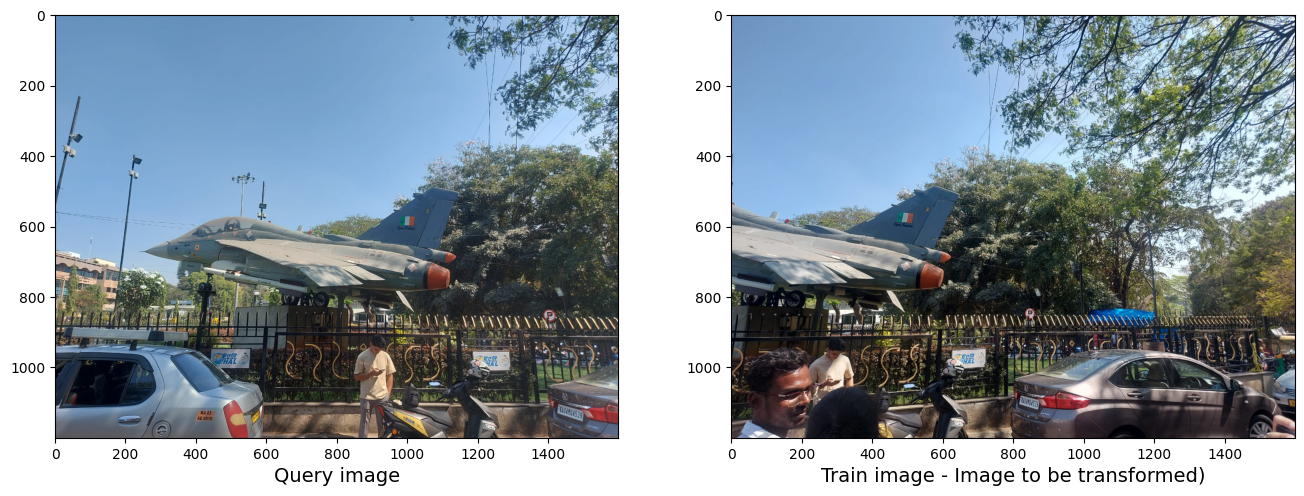

In [3]:
train_image = imageio.imread("./Cubbon_Park/flight3.jpg")
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)

query_image = imageio.imread("./Cubbon_Park/flight2.jpg")
query_image_gray = cv2.cvtColor(query_image,cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_image, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_image, cmap="gray")
ax2.set_xlabel("Train image - Image to be transformed)", fontsize=14)

plt.show()

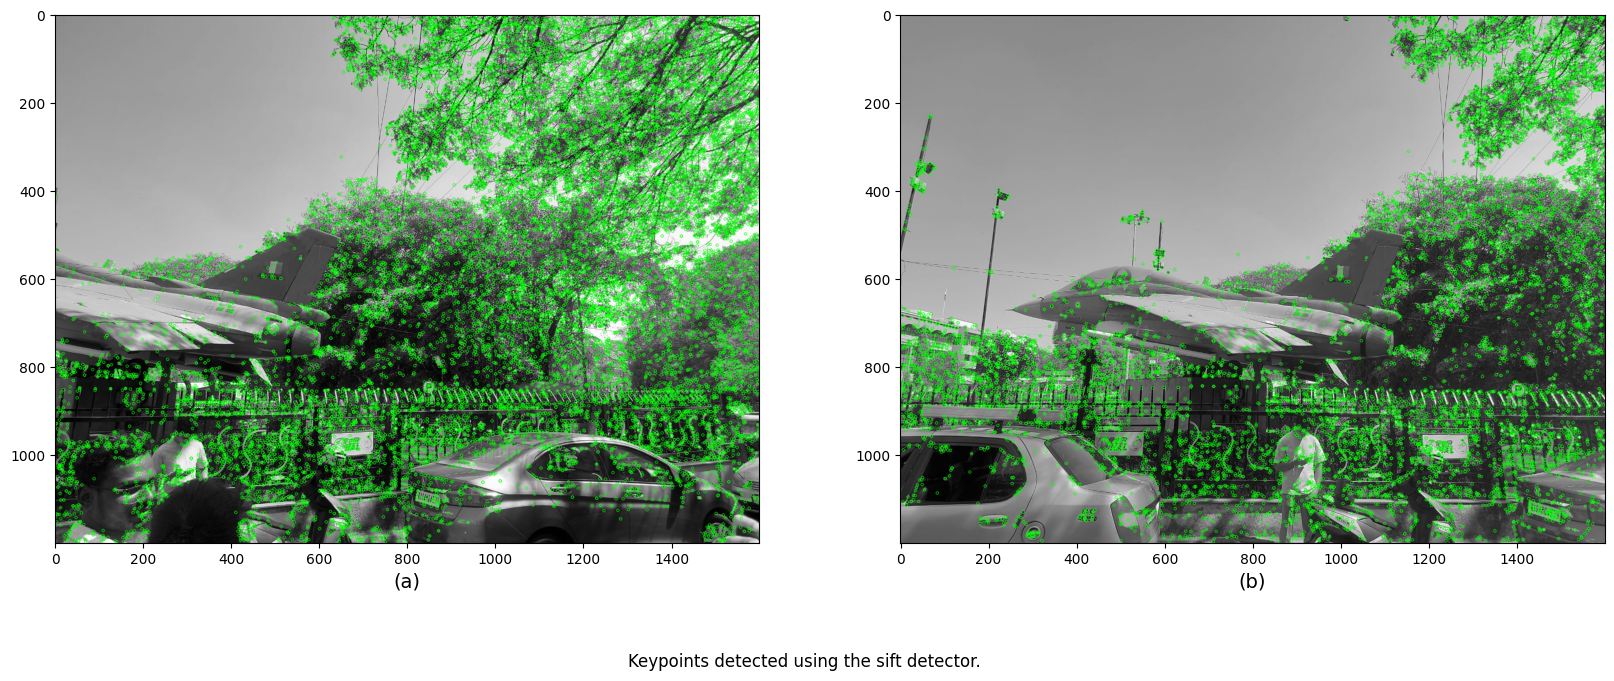

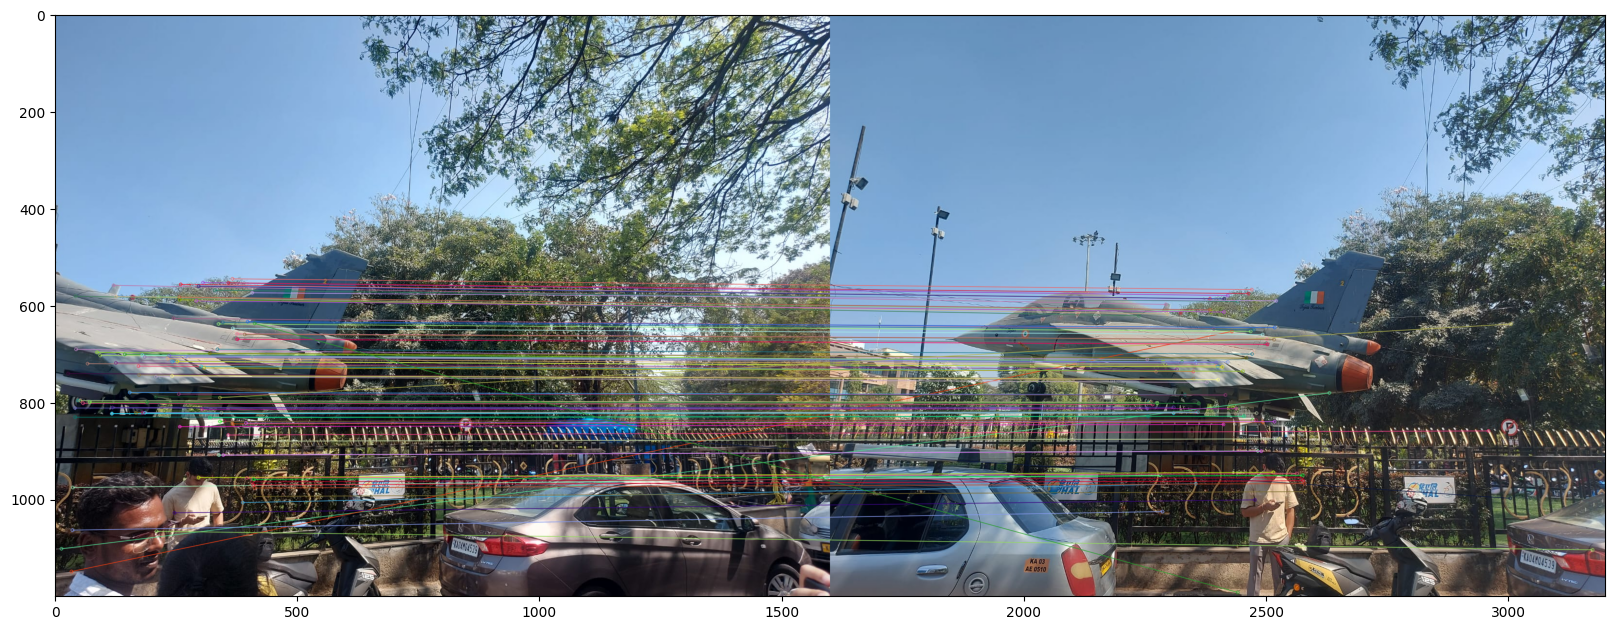

In [4]:
detector = "sift"
keypointsA, featuresA = find_method_descriptor(train_image_gray, method=detector)
keypointsB, featuresB = find_method_descriptor(query_image_gray, method=detector)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(train_image_gray,keypointsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_image_gray,keypointsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)
statement = f'Keypoints detected using the {detector} detector.'

fig.text(0.5, 0.01, statement, ha='center', fontsize=12)
plt.show()

feature_match = "flann"
fig = plt.figure(figsize=(20, 8))

if feature_match == 'flann':
    matches = matchKeyPointsFLANN(featuresA, featuresB, method=detector)
    img3 = cv2.drawMatches(train_image, keypointsA, query_image, keypointsB, matches[:100],
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

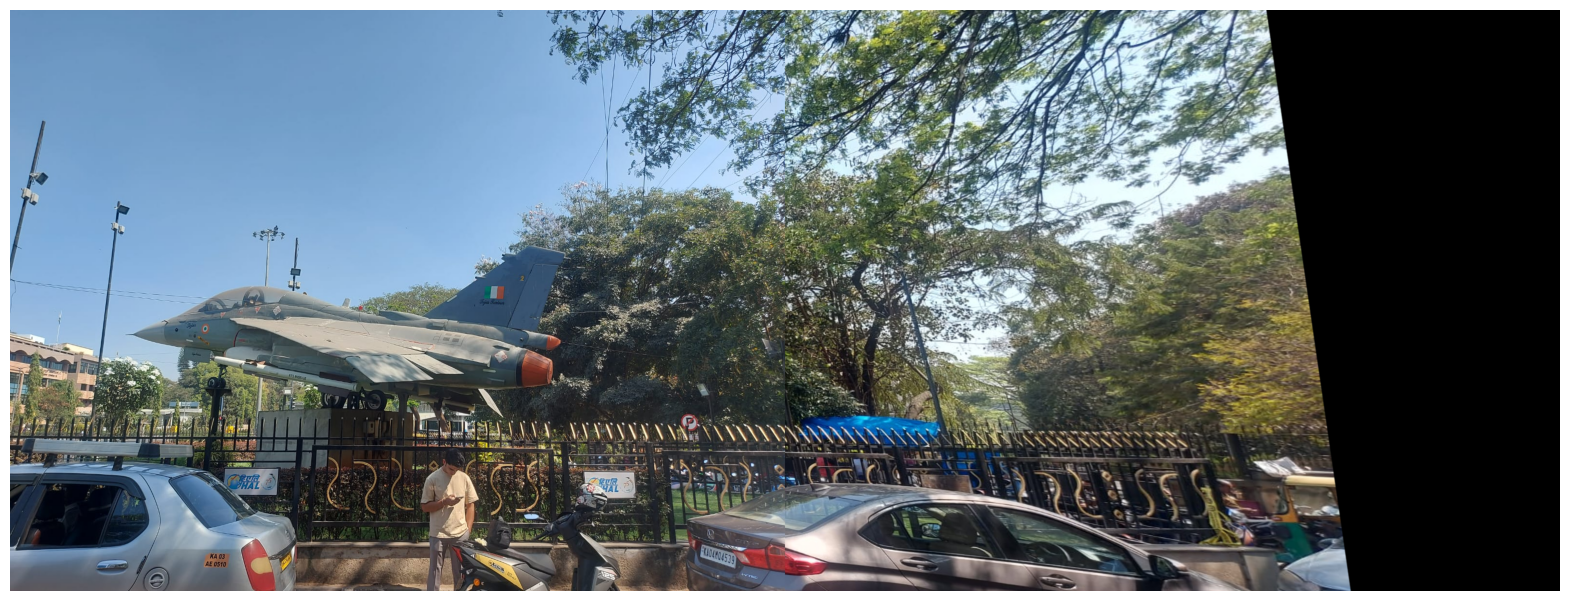

In [5]:
M = getHomography(keypointsA, keypointsB, featuresA, featuresB, matches, reprojThresh=5)
if M is None:
    print("Error!")
(matches, H, status) = M

result = cv2.warpPerspective(train_image, H,
			(train_image.shape[1] + query_image.shape[1], train_image.shape[0]))
result[0:query_image.shape[0], 0:query_image.shape[1]] = query_image

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()
